<h1>PRÁCTICA 2</h1>
<h2>Imports y configuración del Notebook</h2>

In [1]:
# Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# To make this notebook's output stable across runs
np.random.seed(42)

# Configure Jupyter Notebook for displaying HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ensure Python version is >=3.5
import sys
assert sys.version_info >= (3, 5)

# Ensure Scikit-Learn version is >=0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Configure matplotlib and seaborn for visualization
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': [u'times']})

# Configure pandas display options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Ignore specific warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Create output folders if they don't exist
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('output/session2'):
    os.makedirs('output/session2')

C:\Users\carlo\AppData\Local\Temp\ipykernel_5772\3773398339.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<h2>Lectura de datos</h2>

In [2]:
# Leer los datasets
housing = pd.read_csv('dataset/housing-snapshot/train_set.csv', index_col = 0)
housing_validation = pd.read_csv('dataset/housing-snapshot/test_set.csv', index_col = 0)

<h2>Preprocesamiento del dataset</h2>
<p>Para realizar el preprocesamiento de los datos hemos pensado en hacer las siguientes funciones:</p>
<ul>
    <li>
        <b>handle_sensible_outliers:</b>
        Función para eliminar los outliers del dataset.
        <p>Tendremos en cuenta los siguientes factores:</p>
        <ul>
            <li>Casas con más Bedroom2 que Rooms</li>
            <li>Casas con más Bathroom que Rooms </li>
            <li>Casas con Bedroom2 o Bathroom igual a 0</li>
            <li>Casas con más de 4 Car</li>
            <li>Casas con más de 6 Rooms</li>
        </ul>
    </li>
    <br>
    <li>
        <b>handle_missing_and_sensible_data:</b>
        Función para eliminar NaNs y datos sensibles.
        <p>A continuación, mencionamos las características que contienen NaNs y cómo lo gestionamos:</p>
        <ul>
            <li>
                <b>CouncilArea:</b>
                Asignamos el valor más común de CouncilArea según el Postcode.
            </li>
            <li>
                <b>Year Built:</b>
                Asignamos el valor más comun de YearBuilt según el CouncilArea.
            </li>
            <li>
                <b>Car:</b>
                Asignamos el valor medio de Car según CouncilArea.
            </li>
            <li>
                <b>BuildingArea:</b>
                Asignamos el valor medio de BuildingArea según Rooms.
            </li>
            <li>
                <b>Landsize:</b>
                Asignamos el valor medio de Landsize según CouncilArea.
            </li>
         </ul>
    <br>
    <li>
        <b>transform_features_for_price_correlation:</b>
        Función para obtener los precios medios de las características muy correlacionadas con Price.
        <p>Las características más correlacionadas son: SellerG, Postcode, YearBuilt</p>
    </li>
    <br>
    <li>
        <b>encode_categorical_features:</b>
        Función para hacer One Hot Encoding de las características categóricas.
    </li>
    <br>
    <li>
        <b>norm_values:</b>
        Función para normalizar los valores de las características numéricas.
    </li>
</ul>

In [4]:
# Eliminar outliers y valores sin sentido
    # Más Bedrooms que Rooms
    # Más Bathrooms que Rooms
    # Bedrooms o Bathrooms a 0
    # Cars mayores a 4
    # Rooms mayores a 5

def handle_sensible_outliers(dataframes): 
    data = dataframes[0]
    data = data[~((data['Rooms'] < data['Bedroom2']) | (data['Bathroom'] == 0) | (data['Rooms'] < data['Bathroom']) | (data['Car']>=5) | data['Rooms']>=6)]    
    return (data, dataframes[1])


# Eliminar NaNs y datos sensibles
def handle_missing_and_sensible_data(dataframes):
    data = dataframes[0]
    
    # Poner price en la última columna
    if 'Price' in data:
        price_column = data['Price']  
        data = data.drop(columns = ['Price'])  
        data['Price'] = price_column
    
    ## Council Area ##
    # Asignar en los NaNs el valor más común de CouncilArea según el Postcode
    # Si todavía quedan NaNs, rellenar con Unavailable
    mode_council_area_by_postcode = data.groupby('Postcode')['CouncilArea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    data['CouncilArea'] = data['CouncilArea'].fillna(data['Postcode'].map(mode_council_area_by_postcode.set_index('Postcode')['CouncilArea']))
    data['CouncilArea'] = data['CouncilArea'].fillna('Unavailable')
    
    ## Year Built ##
    # Asignar en los NaNs el valor más comun de Year Built según el CouncilArea
    # Si todavía quedan NaNs, rellenar con el valor más común
    mode_year_by_suburb = data.groupby('CouncilArea')['YearBuilt'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    data['YearBuilt'] = data['YearBuilt'].fillna(data['CouncilArea'].map(mode_year_by_suburb.set_index('CouncilArea')['YearBuilt']))
    data['YearBuilt'] = data['YearBuilt'].fillna(data['YearBuilt'].mode().iloc[0])
    
    ## Car ##
    # Asignar en los NaNs el valor medio de Car según el CouncilArea
    mean_car_by_postcode = data.groupby('CouncilArea')['Car'].mean().reset_index()
    mean_car_by_postcode['Car'] = mean_car_by_postcode['Car'].apply(np.ceil) # np.ceil redondea hacia arriba
    data['Car'] = data['Car'].fillna(data['CouncilArea'].map(mean_car_by_postcode.set_index('CouncilArea')['Car']))
    
    # Elimiar filas donde BuildingArea sea NaN
    # Asignar en los NaNs el valor medio de BuildingArea según Rooms
    data_aux = data[~(data['BuildingArea'].isna())]
    data_aux = data_aux.groupby('Rooms')['BuildingArea'].mean().reset_index()
    data = data.merge(data_aux, on = 'Rooms', how = 'left')
    data = data.rename(columns = {'BuildingArea_y': 'BuildingArea'}).drop(columns = {'BuildingArea_x'})
    
    ## Landsize ##
    # Eliminar las filas donde Landsize sea 0
    # Asignar en los NaNs el valor medio de Landsize según el CouncilArea
    # Si todavía quedan NaNs, rellenarlos con el valor más común
    data_aux = data[~(data['Landsize'] == 0)]
    data_aux = data_aux.groupby('CouncilArea')['Landsize'].mean().reset_index()
    data = data.merge(data_aux, on = 'CouncilArea', how = 'left')
    data = data.rename(columns = {'Landsize_y': 'Landsize'}).drop(columns = {'Landsize_x'})
    data['Landsize'] = data['Landsize'].fillna(data['Landsize'].mode().iloc[0])

    return (data, dataframes[1])


# Obtener precios medios de características muy correlacionadas con Price
def transform_features_for_price_correlation(dataframes):
    data = dataframes[0]
    
    features_to_transform = ['SellerG', 'Postcode', 'YearBuilt'] # Características más correlacionadas con Price
    for feature in features_to_transform:
        new_name = 'PriceBy'   
        new_name += feature
        # Asegurar que la característica nueva no esté en el dataset
        if new_name not in data.columns:
            # Sacar la media del Price según la característica en cuestión
            meanPrice_by_feature = data.groupby(feature)['Price'].mean().reset_index()
            mean_price = data['Price'].mean()
            
            # Si la característica tiene Price en NaN, rellenar con la media de Price
            meanPrice_by_feature['Price'].fillna(mean_price, inplace = True)

            # Agregar el precio por característica al dataset
            data = data.merge(meanPrice_by_feature, on = feature, how = 'left')
            # Renombrar las columnas para que se llamen PriceBy*Característica*
            data = data.rename(columns={'Price_y': new_name, 'Price_x' : 'Price'})
                
    return (data, dataframes[1])


# Hacer One Hot Encoding de características categóricas
def encode_categorical_features(dataframes):    
    data = dataframes[0]
    
    # Características categóricas no utilizadas anteriormente
    features_binari = ['Type', 'Method', 'Regionname','CouncilArea','Suburb']
    
    # Por cada característica, si se encuentra en el dataset, crear su One Hot Encoding y eliminar la característica
    for binari in features_binari:
        if binari in data.columns:
            data = data.join(pd.get_dummies(data[binari], prefix=binari), how = 'left')#.drop([binari], axis = 1)
            
    return (data ,dataframes[1])


# Normalizar valores
def norm_values(dataframes):   
    # Crea un objeto StandardScaler
    scaler = StandardScaler()
    
    data = dataframes[0]  
    
    # Columnas a normalizar 
    columns_to_norm = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea', 'Landsize', 'PriceBySellerG', 'PriceByPostcode', 'PriceByYearBuilt']
    order_column = data[columns_to_norm]  
    data = data.drop(columns = columns_to_norm)  
    data[columns_to_norm] = order_column
    
    # Normalizar todas las columnas menos Price
    array_np = data.columns.to_numpy()
    features_to_norm = array_np[-11:] # Seleccionar las 12 últimas columnas
    # Normalizar las columnas entre -1 y 1
    for k in data.columns:
        if k in features_to_norm :
            data[k] = np.log1p(data[k])
            #data[k] = ((data[k] - data[k].min()) / (data[k].max() - data[k].min()) ) * 2 - 1
            data[k] = scaler.fit_transform(data[k].values.reshape(-1, 1))

    return (data, dataframes[1])   

<h2>Preprocesamiento del Validation</h2>
<p>Para realizar el preprocesamiento de los datos hemos pensado en hacer las siguientes funciones:</p>
<ul>
    <li>
        <b>transform_features_for_price_correlation_for_val:</b>
        Función para obtener los precios medios de las características muy correlacionadas con Price.
        <p>Las características más correlacionadas son: SellerG, Postcode, YearBuilt</p>
    </li>
    <br>
    <li>
        <b>encode_categorical_features_for_val:</b>
        Función para hacer One Hot Encoding de las características categóricas.
    </li>
    <br>
    <li>
        <b>norm_values_validation:</b>
        Función para normalizar los valores de las características numéricas.
    </li>
</ul>

In [5]:
# Obtener precios medios de características muy correlacionadas con Price para el conjunto de Validation
def transform_features_for_price_correlation_for_val(dataframes):
    val = dataframes[0]
    data = dataframes[1]
    
    # Características qeu no se encuentran en Validation
    col = ['PriceBySellerG', 'PriceByPostcode', 'PriceByYearBuilt']
    features = ['SellerG', 'Postcode', 'YearBuilt']
    
    # Añadir el valor medio al conjunto de Validation según los valores del dataset
    for i, feature in enumerate(features):
        new_df = data.groupby(feature)[col[i]].mean().reset_index()
        new_df.set_index(feature, inplace = True)
        val = val.merge(new_df, on = feature, how = 'left')
        val[col[i]].fillna(new_df[col[i]].mean(), inplace = True) 
        
    return (val, data)


# Hacer One Hot Encoding de características categóricas en Validation
def encode_categorical_features_for_val(dataframes):
    val = dataframes[0]
    data = dataframes[1]

    # Características categóricas no utilizadas anteriormente
    features_binari = ['Type', 'Method', 'Regionname','CouncilArea','Suburb']

    # Por cada característica, si se encuentra en el Validation, crear su One Hot Encoding y eliminar la característica   
    for binari in features_binari:
        if binari in val.columns:
            val = val.join(pd.get_dummies(val[binari], prefix=binari), how = 'left')#.drop([binari], axis = 1)

    # Añadir columnas en Validation que se encuentran en dataset y no en Validation excepto Price y ponerlas a 0 por defecto
    extra_columns = set(data.columns) - set(val.columns)
    for column in extra_columns:
            if column != 'Price':
                val[column] = 0
                
    return (val, data)


# Normalizar valores de Validation
def norm_values_validation(dataframes):
    # Crea un objeto StandardScaler
    scaler = StandardScaler()
    
    val = dataframes[0]    
    # Columnas a normalizar
    columns_to_norm = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea', 'Landsize', 'PriceBySellerG', 'PriceByPostcode', 'PriceByYearBuilt']
    order_column = val[columns_to_norm]  
    val = val.drop(columns = columns_to_norm)  
    val[columns_to_norm] = order_column
    
    features_to_norm = ['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea', 'Landsize', 'Distance']
    
    # Normalizar las columnas entre -1 y 1
    for k in val.columns:
        if k in features_to_norm :
            val[k] = np.log1p(val[k])
            #val[k] = ((val[k] - val[k].min()) / (val[k].max() - val[k].min()) ) * 2 - 1
            val[k] = scaler.fit_transform(val[k].values.reshape(-1, 1))

    return (val, dataframes[1])  

<h2>Pipelines</h2>
<p>Para realizar las funciones anteriores de una forma más eficaz, organizada y automatizada, utilizamos Pipelines. A estas les pasamos funciones de limpieza, extracción de características, codificación y normalización con la finalidad de preprocesar los datos tanto del dataset como de Validation.<p>

In [6]:
# Pipeline para el dataset
# Tratar outliers
# Tratar NaN y datos sensibles
# Obtener características correlacionadas al Price
# Hacer One Hot Encoding de características categóricas
# Normalizar valores
data_pipeline = Pipeline([
        ('handle_sensible_outliers', FunctionTransformer(func = handle_sensible_outliers, validate = False)),
        ('handle_missing_and_sensible_data', FunctionTransformer(func = handle_missing_and_sensible_data, validate = False)),
        ('transform_features_for_price_correlation', FunctionTransformer(func = transform_features_for_price_correlation, validate = False)),
        ('encode_categorical_features', FunctionTransformer(func = encode_categorical_features, validate = False)),
        ('norm_values', FunctionTransformer(func = norm_values, validate = False))
    ])
housing_num_tr = data_pipeline.fit_transform((housing, housing))[0]


# Pipeline para el Validation
# Tratar NaN y datos sensibles
# Obtener características correlacionadas al Price del dataset
# Hacer One Hot Encoding de características categóricas
# Normalizar valores
validation_pipeline = Pipeline([
        ('handle_missing_and_sensible_data', FunctionTransformer(func = handle_missing_and_sensible_data, validate = False)),
        ('transform_features_for_price_correlation', FunctionTransformer(func = transform_features_for_price_correlation_for_val, validate = False)),
        ('encode_categorical_features', FunctionTransformer(func = encode_categorical_features_for_val, validate = False)),
        ('norm_values', FunctionTransformer(func = norm_values_validation, validate = False))
    ])
housing_num_val = validation_pipeline.fit_transform((housing_validation, housing_num_tr))[0]

In [7]:
# Separar el dataset en train y test de manera equilibrada
housing_num_tr["price_cat"] = pd.cut(housing_num_tr["Price"], bins = [0., 500000, 1000000, 1500000, 2000000., np.inf], labels = [1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing_num_tr, housing_num_tr["price_cat"]):
    train_set = housing_num_tr.loc[train_index]
    test_set = housing_num_tr.loc[test_index]
     
train_set = train_set.drop(["price_cat"],axis = 1)     
test_set = test_set.drop(["price_cat"],axis = 1)

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Distance'}>,
        <AxesSubplot:title={'center':'Bedroom2'}>],
       [<AxesSubplot:title={'center':'Car'}>,
        <AxesSubplot:title={'center':'BuildingArea'}>,
        <AxesSubplot:title={'center':'Landsize'}>],
       [<AxesSubplot:title={'center':'Propertycount'}>,
        <AxesSubplot:title={'center':'PriceBySellerG'}>,
        <AxesSubplot:title={'center':'PriceByPostcode'}>],
       [<AxesSubplot:title={'center':'PriceByYearBuilt'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

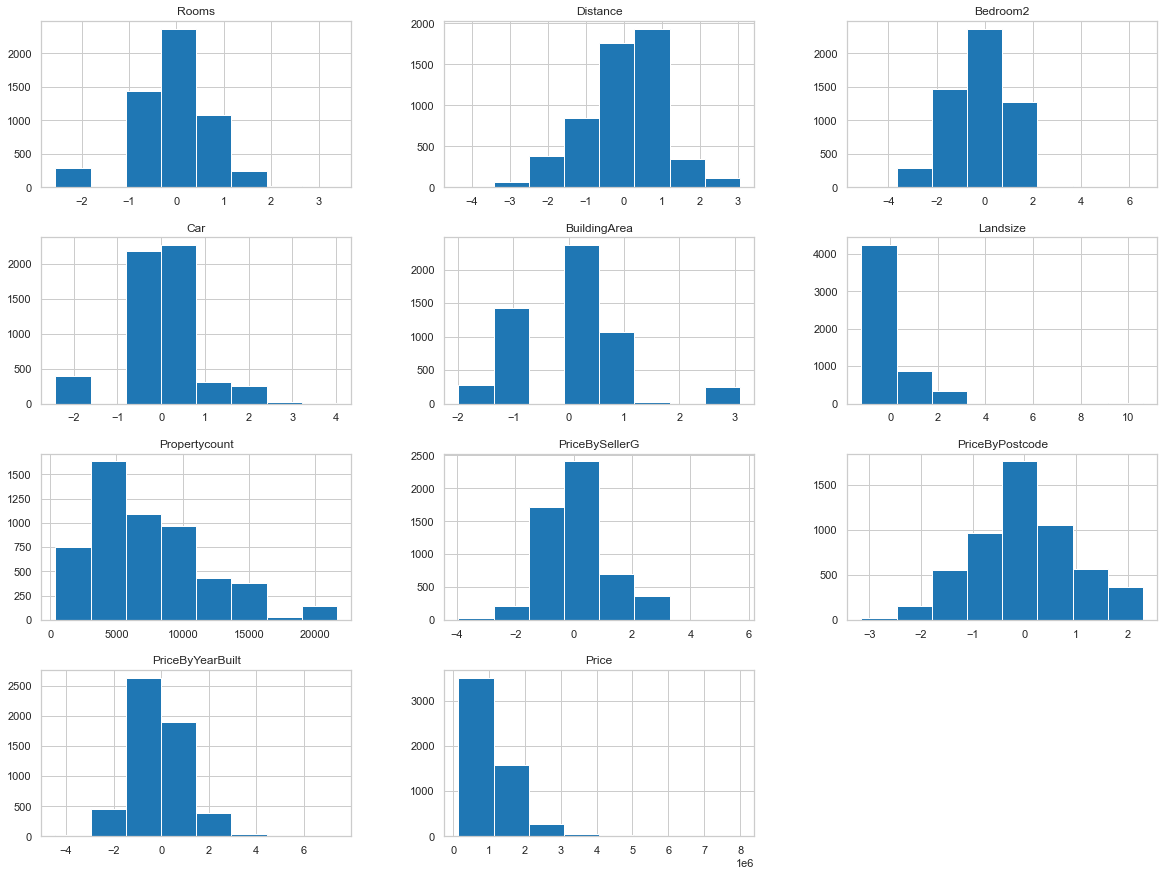

In [8]:
temp = housing_num_tr[['Rooms', 'Distance', 'Bedroom2', 'Car', 'BuildingArea', 'Landsize', 'Propertycount', 'PriceBySellerG', 'PriceByPostcode',
                       'PriceByYearBuilt', 'Price']]

temp.hist(bins = 8, figsize = (20, 15))

In [9]:
housing_num_tr_numerical = train_set.select_dtypes(include=[np.number])
housing_num_tr_numerical

,Postcode,YearBuilt,Lattitude,Longtitude,Propertycount,Price,Type_h,Type_t,Type_u,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,CouncilArea_Banyule,CouncilArea_Bayside,CouncilArea_Boroondara,CouncilArea_Brimbank,CouncilArea_Cardinia,CouncilArea_Casey,CouncilArea_Darebin,CouncilArea_Frankston,CouncilArea_Glen Eira,CouncilArea_Greater Dandenong,CouncilArea_Hobsons Bay,CouncilArea_Hume,CouncilArea_Kingston,CouncilArea_Knox,CouncilArea_Macedon Ranges,CouncilArea_Manningham,CouncilArea_Maribyrnong,CouncilArea_Maroondah,CouncilArea_Melbourne,CouncilArea_Melton,CouncilArea_Monash,CouncilArea_Moonee Valley,CouncilArea_Moreland,CouncilArea_Nillumbik,CouncilArea_Port Phillip,CouncilArea_Stonnington,CouncilArea_Unavailable,CouncilArea_Whitehorse,CouncilArea_Whittlesea,CouncilArea_Wyndham,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,Suburb_Ardeer,Suburb_Armadale,Suburb_Ascot Vale,Suburb_Ashburton,Suburb_Ashwood,Suburb_Aspendale,Suburb_Aspendale Gardens,Suburb_Attwood,Suburb_Avondale Heights,Suburb_Balaclava,Suburb_Balwyn,Suburb_Balwyn North,Suburb_Bayswater,Suburb_Bayswater North,Suburb_Beaumaris,Suburb_Bellfield,Suburb_Bentleigh,Suburb_Bentleigh East,Suburb_Berwick,Suburb_Black Rock,Suburb_Blackburn,Suburb_Blackburn North,Suburb_Blackburn South,Suburb_Boronia,Suburb_Box Hill,Suburb_Braybrook,Suburb_Briar Hill,Suburb_Brighton,Suburb_Brighton East,Suburb_Broadmeadows,Suburb_Brooklyn,Suburb_Brunswick,Suburb_Brunswick East,Suburb_Brunswick West,Suburb_Bulleen,Suburb_Bundoora,Suburb_Burnley,Suburb_Burnside,Suburb_Burnside Heights,Suburb_Burwood,Suburb_Burwood East,Suburb_Cairnlea,Suburb_Camberwell,Suburb_Campbellfield,Suburb_Canterbury,Suburb_Carlton,Suburb_Carlton North,Suburb_Carnegie,Suburb_Caroline Springs,Suburb_Carrum,Suburb_Carrum Downs,Suburb_Caulfield,Suburb_Caulfield East,Suburb_Caulfield North,Suburb_Caulfield South,Suburb_Chadstone,Suburb_Chelsea,Suburb_Chelsea Heights,Suburb_Cheltenham,Suburb_Chirnside Park,Suburb_Clarinda,Suburb_Clayton,Suburb_Clayton South,Suburb_Clifton Hill,Suburb_Coburg,Suburb_Coburg North,Suburb_Collingwood,Suburb_Craigieburn,Suburb_Cranbourne,Suburb_Cranbourne North,Suburb_Cremorne,Suburb_Croydon,Suburb_Croydon Hills,Suburb_Croydon North,Suburb_Dallas,Suburb_Dandenong,Suburb_Dandenong North,Suburb_Deepdene,Suburb_Deer Park,Suburb_Delahey,Suburb_Derrimut,Suburb_Diamond Creek,Suburb_Diggers Rest,Suburb_Dingley Village,Suburb_Docklands,Suburb_Doncaster,Suburb_Doncaster East,Suburb_Donvale,Suburb_Doveton,Suburb_Eaglemont,Suburb_East Melbourne,Suburb_Edithvale,Suburb_Elsternwick,Suburb_Eltham,Suburb_Eltham North,Suburb_Elwood,Suburb_Endeavour Hills,Suburb_Epping,Suburb_Essendon,Suburb_Essendon North,Suburb_Essendon West,Suburb_Fairfield,Suburb_Fawkner,Suburb_Ferntree Gully,Suburb_Fitzroy,Suburb_Fitzroy North,Suburb_Flemington,Suburb_Footscray,Suburb_Forest Hill,Suburb_Frankston,Suburb_Frankston North,Suburb_Frankston South,Suburb_Gardenvale,Suburb_Gisborne,Suburb_Gladstone Park,Suburb_Glen Huntly,Suburb_Glen Iris,Suburb_Glen Waverley,Suburb_Glenroy,Suburb_Gowanbrae,Suburb_Greensborough,Suburb_Greenvale,Suburb_Hadfield,Suburb_Hallam,Suburb_Hampton,Suburb_Hampton East,Suburb_Hampton Park,Suburb_Hawthorn,Suburb_Hawthorn East,Suburb_Healesville,Suburb_Heathmont,Suburb_Heidelberg,Suburb_Heidelberg Heights,Suburb_Heidelberg West,Suburb_Highett,Suburb_Hillside,Suburb_Hoppers Crossing,Suburb_Hughesdale,Suburb_Huntingdale,Suburb_Hurstbridge,Suburb_Ivanhoe,Suburb_Ivanhoe East,Suburb_Jacana,Suburb_Kealba,Suburb_Keilor,Suburb_Keilor Downs,Suburb_Keilor East,Suburb_Keilor Lodge,Suburb_Keilor Park,S

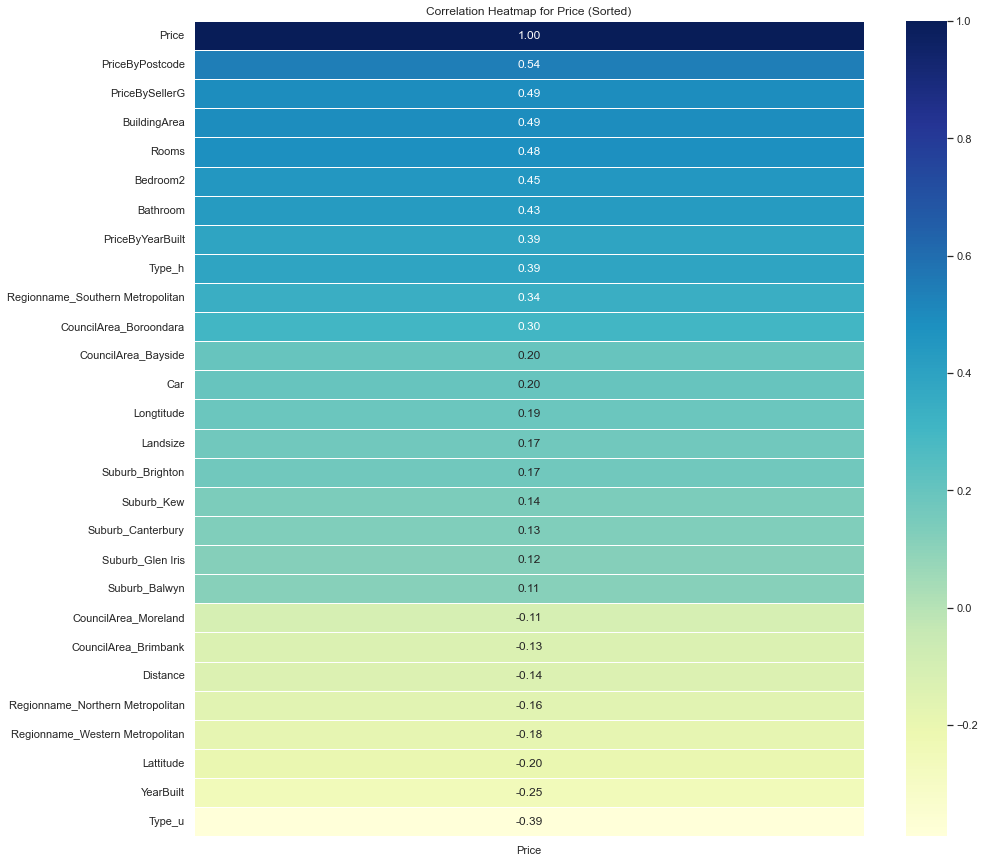

In [10]:
# Calcular correlaciones con Price
price_correlations = housing_num_tr_numerical.corr()['Price'].round(2)

# Filtrar correlaciones mayores a 0.1
price_correlations = price_correlations[abs(price_correlations) > 0.1]

# Ordenar correlaciones de forma descendente
sorted_correlations = price_correlations.sort_values(ascending = False)

# Crear un mapa de calor
plt.figure(figsize = (15, 15))
sns.heatmap(sorted_correlations.to_frame(), annot = True, cmap = "YlGnBu", fmt = ".2f", linewidths = 0.5)
plt.title("Correlation Heatmap for Price (Sorted)")
plt.show()




<h2>Modelo y predicciones</h2>
<p>Antes de escoger un modelo, hemos realizado un PCA para reducir la dimensionalidad de los datos y, por lo tanto, reducir la complejidad del conjunto de datos.</p>

<p>Hemos escogido el modelo RandomForestRegressor porque presenta un conjunto de características que consideramos adecuadas para este problema.<p>
<ol>
    <li>
        <b>Modelo robusto y versátil:</b>
        Puede manejar una amplia variedad de problemas de regresión. Es una extensión del algoritmo de <i>Árboles de decisión</i> y combina múltiples árboles para obtener un rendimiento mejor que un solo árbol.
    </li>
    <li>
        <b>Reducción del overfitting:</b>
        Tiende a reducir el overfitting en comparación con un solo árbol. Al combinar múltiples árboles entrenados en subconjuntos aleatorios de datos, el modelo generalzia mejor a nuevos datos, lo que lo hace menos propenso a ajustarse demasiado a los datos de entrenamiento.
    </li>
    <li>
        <b>Manejo de características:</b>
        Puede manejar automáticamente la importancia de las características en la regresión. Puede obtener una estimación de la importancia relativa de cada característica en la predicción, lo que es útil para el análisis y la selección de características.
    </li>
    <li>
        <b>No requiere normalización de datos:</b>
        A diferencia de otros algoritmos, este no requiere que las características se normalicen o estandaricen. Se puede usar directamente con características en diferentes escalas.
    </li>
    <li>
        <b>Resistencia al ruido y valores atípicos:</b>
        Tiende a ser resistente al ruido y a los valores atípicos en los datos, lo que lo hace adecuado para conjuntos de datos reales que pueden contener imperfecciones.
    </li>
    <li>
        <b>Manejo de datos faltantes:</b>
        Puede manejar datos faltantes de manera efectiva sin requerir una entrada exhaustiva de valores faltantes.
    </li>
    <li>
        <b>Buena capacidad predictiva:</b>
        Tiende a proporcionar un rendimiento sólido en una variedad de problemas de regresión.
    </li>
</ol>

In [23]:
# Modelo RandomForestRegressor
forest = RandomForestRegressor()
features = ['Rooms','Distance','Bathroom','Car','Lattitude','Longtitude','Landsize','Type_h','Type_u',
            'Type_t','Regionname_Southern Metropolitan','Regionname_Western Metropolitan','PriceBySellerG',
            'PriceByPostcode','PriceByYearBuilt','CouncilArea_Boroondara','Method_VB','Method_SP',
            'Method_PI','Method_S','Method_SA']

# Entrenar el modelo
X = train_set[features]
y = train_set['Price']

forest.fit(X, y)

RandomForestRegressor()

----- EVALUATION ON TRAIN SET ------
RMSE 310069.80172304396
R^2:  0.7811247813132312


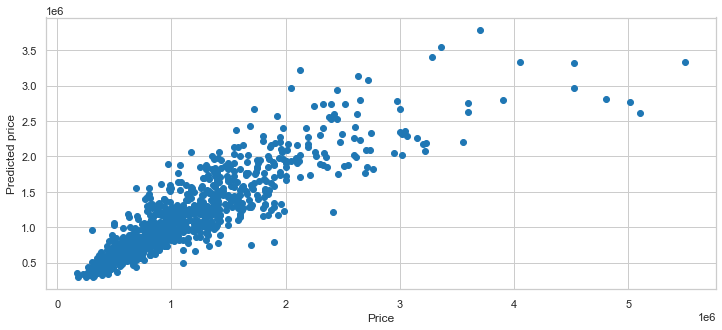

In [24]:
X_test = test_set[features].fillna(0)
y_test = test_set['Price']

y_pred = forest.predict(X_test)


# Evaluar el modelo
print("----- EVALUATION ON TRAIN SET ------")
print("RMSE",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2: ",r2_score(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('Price')
plt.ylabel('Predicted price');
plt.show()


<h2>Definición del modelo y parámetros a sintonizar </h2>
<p>Aquí utilizamos la búsqueda cuadrículada (GridSearchCV) con el modelo de Random FOrest Regressor para encontrar la combinación óptima de hipeparámetros para el modelo. </p>

<ol>
    <li>
        <b>n_estimators:</b>
        Número de árboles en el bosque.
    </li>
    <li>
        <b>min_samples_split:</b>
        Número mínimo de muestras requeridas para dividir un nodo interno.
    </li>
    <li>
        <b>max_depth:</b>
        Profundidad máxima de los árboles. None significa que los nodos se expandirán hasta que contengan menos de min_samples_split muestras.
    </li>

</ol>

In [ ]:
from sklearn.model_selection import GridSearchCV
forest = RandomForestRegressor()

param_grid = {
    "n_estimators":[500,550],
    "min_samples_split": [2,4],
    "max_depth": [None,4,8]
    
}

<h2>Configuración de la Búsqueda en Cuadrícula </h2>
<p>Creamos una instancia de GridSearchCV con el modelo (forest), los parámetros a sintonizar (param_grid), número de divisiones en validación cruzada (cv=5), métrica de evaluación (scoring="neg_mean_squared_error"), y la opción de retornar resultados de entrenamiento (return_train_score = True). </p>

In [81]:
grid_search = GridSearchCV(forest, param_grid,cv=5,
                         scoring="neg_mean_squared_error",
                         return_train_score = True)
X_train = housing_num_tr[features]
y_train = housing_num_tr['Price']
grid_search.fit(X_train,y_train )

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 4, 8], 'min_samples_split': [2, 4],
                         'n_estimators': [500, 550]},
             return_train_score=True, scoring='neg_mean_squared_error')

<h2>Mejor Modelo y Resultados </h2>
<p>En este punto obtenemos el mejor estimador (modelo) de la búsqueda en cuadrícula. </p>

In [82]:
best_forest = grid_search.best_estimator_
print(best_forest)

RandomForestRegressor(n_estimators=500)


In [83]:
# Predecir el conjunto de test y generar el archivo de submission
X_test = housing_num_val[features].fillna(0)
y_pred = best_forest.predict(X_test)


df_output = pd.DataFrame(y_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','Price']

df_output.to_csv('output/session2/baseline.csv',index=False)


<p>Práctica realizada por Carlos Gómez Domínguez, Pablo Noriega Vázquez y Adrián Galán Pacheco.</p>